In [271]:
# Import libraries
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split

# Load the first dataset
# dataset1_url ="https://github.com/SevithaJanga03/LLM---Detect-AI-Generated-Text/blob/main/merged_essays.csv"
df = pd.read_csv('merged_essays.csv')

# Display dataset
print(df.head())

# Specify the features (X) and target variable (y)
X = df
y = df['generated']

# Split the dataset into training and development sets
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Development set shape:", X_dev.shape, y_dev.shape)

         id  prompt_id                                               text  \
0  0059830c          0  Cars. Cars have been around since they became ...   
1  005db917          0  Transportation is a large necessity in most co...   
2  008f63e3          0  "America's love affair with it's vehicles seem...   
3    940276          0  How often do you ride in a car? Do you drive a...   
4  00c39458          0  Cars are a wonderful thing. They are perhaps o...   

   generated  
0          0  
1          0  
2          0  
3          0  
4          0  
Training set shape: (1041, 4) (1041,)
Development set shape: (447, 4) (447,)


In [272]:
from collections import Counter
from collections import defaultdict

my_dictionary= {}
no_of_human_documents = 0
no_of_llm_documents = 0

def build_vocabulary(essay, min_occurrence=5):

    # Flatten the list of sentences into a single list of words
    all_words = [word.lower() for word in essay.split()]

    # Count the occurrences of each word
    word_counts = Counter(all_words)

    # Filter out rare words based on the minimum occurrence threshold
    vocabulary = {word : count for word, count in word_counts.items() if count >= min_occurrence}

    return vocabulary

for index,row in X_train.iterrows():
  vocabulary = build_vocabulary(row['text'])
  if(row['generated'] == 0):
    no_of_human_documents += 1
    Class_voc={'HUMAN':0}
    Class_voc.update(vocabulary)
  else:
    no_of_llm_documents += 1
    Class_voc={'LLM':1}
    Class_voc.update(vocabulary)
  try:
    my_dictionary[row['id']].append(Class_voc)
  except KeyError:
    my_dictionary = {**my_dictionary, **{row['id']: Class_voc}}

print(dict(list(my_dictionary.items())[0:10]))

{'eafb8a56': {'LLM': 1, 'car': 5, 'to': 5, 'of': 6, 'the': 8, 'our': 5, 'a': 6, 'be': 5, 'for': 5, 'and': 6, 'it': 5}, 'aa0b24ef': {'HUMAN': 0, 'there': 5, 'or': 7, 'not': 7, 'we': 5, 'the': 54, 'electoral': 13, 'have': 7, 'it': 6, 'and': 7, 'vote': 7, 'on': 5, 'i': 5, 'is': 10, 'to': 25, 'election': 5, 'for': 9, 'of': 17, 'if': 6, 'system': 5, 'would': 11, 'people': 7, 'feel': 6, 'their': 15, 'votes': 6, 'matter': 5, 'more': 5, 'they': 10, 'electors': 6, 'that': 16, 'in': 12, 'are': 8, 'you': 9, 'your': 5, 'states': 7, 'candidates': 5, 'were': 6, 'because': 5, 'votes.': 5}, 'b9229a95': {'HUMAN': 0, 'in': 15, 'the': 36, 'electoral': 11, 'college': 10, ',': 9, 'popular': 6, 'vote': 11, 'would': 7, 'be': 6, 'a': 19, 'chance': 5, 'for': 9, 'to': 13, 'voice': 5, 'is': 5, 'how': 6, 'voters': 6, 'and': 5, 'of': 7, 'tie': 6, 'then': 5, 'paragraph': 5, 'it': 5, 'that': 6, 'president': 7, 'electors': 5, 'who': 5, 'thats': 5, 'we': 6, 'have': 8}, 'e5dcf622': {'HUMAN': 0, 'not': 10, 'the': 45, 'e

In [273]:
def calculate_probability(word, documents):
    num_documents_with_word = sum(1 for document in documents.values() if word in document)
    # Calculate the probability
    probability = num_documents_with_word / len(X_train)
    return probability

def calculate_conditional_probability(word, documents,class_label):
    num_documents_in_class=0
    num_positive_documents=0
    for document in documents.values():
      if(word in document and list(document.items())[0][0]==class_label):
        num_positive_documents=num_positive_documents+1
      if(list(document.items())[0][0]==class_label):
        num_documents_in_class=num_documents_in_class+1
    probability = num_positive_documents / num_documents_in_class
    return probability

# Word for class probability is calculated
target_word = "the"
class_label = "LLM"
# Calculate the probability of the word
probability = calculate_probability(target_word, my_dictionary)
llm_conditional_probability = calculate_conditional_probability(target_word, my_dictionary,class_label)

# Display the result
print(f"Probability of '{target_word}': {probability:.4f}")
print(f"Probability of '{target_word} in {class_label} class ': {llm_conditional_probability:.4f}")

Probability of 'the': 0.9817
Probability of 'the in LLM class ': 0.9024


In [270]:
import math

X_train_data = X_train[['text','generated']].values.tolist()
X_dev_data=X_dev[['text','generated']].values.tolist()

def tokenize(text):
    return nltk.word_tokenize(text.lower())

def count_words(data):
  word_counts = defaultdict(int)
  class_counts = defaultdict(int)

    # Iterate through each entry in the dataset
  for text, label in data:
    words = tokenize(text)

    words_counts = Counter(words)
    min_occurrence = 5

    # Filter out rare words based on the minimum occurrence threshold
    vocabulary = [word  for word,count in words_counts.items() if count >= min_occurrence]

    # Caluculating number of essays of each class
    class_counts[label] += 1

    # Count of each word with respective of that class
    for word in vocabulary:
      word_counts[(word, label)] += 1

  return word_counts, class_counts

def calculate_probabilities(word_counts, class_counts ,smoothing=0.2):

    vocabulary_size = len(set(word for word, _ in word_counts.keys()))
    probabilities = defaultdict(int)

    for (word, label), count in word_counts.items():
        prob_word_given_class = ((count + smoothing) / (class_counts[label] + smoothing * vocabulary_size))
        log_prob_word_given_class = math.log(prob_word_given_class)
        probabilities[(word, label)] = log_prob_word_given_class

    return probabilities

def predict_class(text,probabilities, class_count,smoothing):
  words = tokenize(text)
  log_prob_human = 1
  log_prob_llm = 1
  for word in words:
        log_prob_human *= probabilities.get((word, 0), smoothing )
        log_prob_llm *= probabilities.get((word, 1), smoothing )

  log_prob_human *= math.log(class_count[0]/(class_count[0]+class_count[1]))
  log_prob_llm *= math.log(class_count[1]/(class_count[0]+class_count[1]))

  final_prob_human = log_prob_human / (log_prob_human + log_prob_llm)
  final_prob_llm = log_prob_llm / (log_prob_human + log_prob_llm)

  return 0 if final_prob_human >= final_prob_llm else 1

def evaluate_accuracy(dev_data, probabilities, class_count,smoothing=0.2):
    correct_predictions = 0

    for text, true_label in dev_data:
        predicted_label = predict_class(text, probabilities, class_count,smoothing)
        if predicted_label == true_label:
            correct_predictions += 1

    accuracy = correct_predictions / len(dev_data)
    return accuracy

words_count,class_count = (count_words(X_train_data))
print('Class 0 is HUMAN \nClass 1 is LLM')
print('\nWords count ("word","class" ==> count) : ',words_count)
print('Class Count ("class" ==> count) : ',class_count)

probabilities_of_each_word = calculate_probabilities(words_count, class_count)
print('\nProbability of word in that particular class ("word","class" ==> probability) : ',probabilities_of_each_word)

accuracy = evaluate_accuracy(X_dev_data, probabilities_of_each_word, class_count)
print(f"\nAccuracy on dev data: {accuracy}")




Class 0 is HUMAN 
Class 1 is LLM

Words count ("word","class" ==> count) :  defaultdict(<class 'int'>, {('car', 1): 1, (',', 1): 73, ('to', 1): 40, ('of', 1): 65, ('.', 1): 67, ('the', 1): 74, ('our', 1): 4, ('a', 1): 58, ('be', 1): 1, ('for', 1): 12, ('and', 1): 67, ('it', 1): 4, (',', 0): 929, ('there', 0): 140, ('or', 0): 148, ('not', 0): 392, ('we', 0): 254, ('the', 0): 951, ('electoral', 0): 418, ('college', 0): 392, ('have', 0): 442, ('it', 0): 607, ('and', 0): 903, ('vote', 0): 393, ('on', 0): 244, ('president', 0): 262, ('.', 0): 959, ('i', 0): 123, ('is', 0): 815, ('to', 0): 938, ('election', 0): 99, ('for', 0): 624, ('of', 0): 943, ('states', 0): 245, ('if', 0): 136, ('system', 0): 108, ('would', 0): 214, ('people', 0): 449, ('feel', 0): 5, ('their', 0): 190, ('votes', 0): 150, ('matter', 0): 2, ('more', 0): 164, ('they', 0): 347, ('now', 0): 7, ("n't", 0): 149, ('electors', 0): 166, ('that', 0): 726, ('in', 0): 905, ('are', 0): 552, ('you', 0): 252, ('your', 0): 65, ('``', 0

In [274]:
def derive_top_words(probabilities, label, top_n=10):
    words_prob = [(word, prob) for (word, l), prob in probabilities.items() if l == label]
    words_prob.sort(key=lambda x: x[1], reverse=True)
    return words_prob[:top_n]



def apply_smoothing(train_data, dev_data,smoothing_values):

    for smoothing in smoothing_values:
        word_counts, class_counts = count_words(train_data)
        class_probabilities = {label: count / len(train_data) for label, count in class_counts.items()}
        probabilities = calculate_probabilities(word_counts, class_counts, smoothing)

        accuracy = evaluate_accuracy(dev_data, probabilities, class_probabilities,smoothing)
        all_accuracy.append(accuracy)
        print(f"\nAccuracy on dev data with smoothing {smoothing}: {accuracy}")


all_accuracy = []
smoothing_values = [0.2, 0.3, 0.4, 0.5]
apply_smoothing(X_train_data, X_dev_data,smoothing_values)

top_words_human = derive_top_words(probabilities_of_each_word, 0)
top_words_llm = derive_top_words(probabilities_of_each_word, 1)

print("\nTop 10 words predicting human essays:")
for word, prob in top_words_human:
    print(f"{word}: {prob}")

print("\nTop 10 words predicting LLM-generated essays:")
for word, prob in top_words_llm:
    print(f"{word}: {prob}")



Accuracy on dev data with smoothing 0.2: 0.8948545861297539

Accuracy on dev data with smoothing 0.3: 0.7651006711409396

Accuracy on dev data with smoothing 0.4: 0.6577181208053692

Accuracy on dev data with smoothing 0.5: 0.5727069351230425

Top 10 words predicting human essays:
.: -0.1512273116981234
the: -0.15960257003485576
of: -0.16804856618826675
to: -0.1733637695170702
,: -0.18300291451517384
a: -0.1927358776900596
in: -0.20917100165204558
and: -0.21138290257597556
is: -0.31389343350291277
that: -0.4295014564311924

Top 10 words predicting LLM-generated essays:
the: -1.1688622313451122
,: -1.1824309605511811
.: -1.267953133989343
and: -1.267953133989343
of: -1.2981669125858397
a: -1.4117410267810548
to: -1.7817593858934715
electoral: -2.2487823870010697
in: -2.2487823870010697
college: -2.4216251998404803


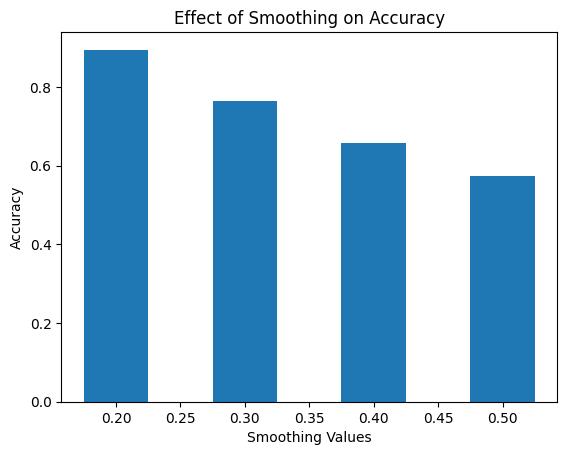

In [275]:
from matplotlib import pyplot as plt
plt.bar(smoothing_values, all_accuracy,width=0.05)
plt.xlabel('Smoothing Values')
plt.ylabel('Accuracy')
plt.title('Effect of Smoothing on Accuracy')
plt.show()